In [1]:
#Imports
import os
import sys
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Load 31P File
file="31P_Favi_600"

data=[]

with open(file) as fh:
    for line in fh:
        data.append(float(line))

#Time domain
TD=len(data)
measured_spectrum=[j/float(max(data)) for j in data]
measured_spectrum=[j-min(measured_spectrum)*0.2 for j in measured_spectrum]
measured_spectrum=[j/float(max(measured_spectrum)) for j in measured_spectrum]
liter=range(TD)


In [4]:
###Function to calculate FID
def calulate_FID_and_FFT(LBaxi_1,LBaxi_2,LBhex_1,LBhex_2,LBiso_1,LBiso_2,csa1,csa2,axi1,axi2,hex1,hex2,iso1,iso2,a1,a2,c1,c2,w_larmor,TD,w_0,delta1,delta2,DW,isoshift1,isoshift2):
    #LB1,LB2,LB3,csa,axi,hex,iso,a,c,w_larmor,TD,w_0,delta,DW,isoshift):
    ###Set the values the simulation will run over
    #values that will be calculated over (x-values)
    i=range(TD)
    #angles that will be calculated over
    m=180
    n1=range(m)
    #Calculate beta(n1)
    beta_n1=[((90/float(m))*j*(math.pi/float(180))) for j in n1]
    #Calculate FID
    #print("fid_1")
    fid_1=[]
    for jn in i:
        sum_axi=0
        sum_hex=0
        sum_iso=0
        for k in n1:
            sum_axi+=cmath.exp(1j*((delta1/float(2))*(3*math.cos(beta_n1[k])**2-1)*jn*DW))*((c1**2*math.sin(beta_n1[k]))/float(math.sin(beta_n1[k])**2+((c1/float(a1))**2)*math.cos(beta_n1[k])**2)**2)
            sum_hex+=cmath.exp(1j*((-delta1/float(4))*(3*math.cos(beta_n1[k])**2-1)*jn*DW))*math.sin(beta_n1[k])
            sum_iso+=cmath.exp(1j*(-isoshift1)*w_0*jn*DW)*math.sin(beta_n1[k])
        #Muliplying the non-sum influenced factors
        zsum_axi=axi1*sum_axi*math.exp(-jn*DW*LBaxi_1*math.pi)
        zsum_hex=hex1*sum_hex*math.exp(-jn*DW*LBhex_1*math.pi)
        zsum_iso=iso1*sum_iso*math.exp(-jn*DW*LBiso_1*math.pi)
        zsum=zsum_axi+zsum_hex+zsum_iso
        fid_1.append(zsum)
    #print("fid_2")
    fid_2=[]
    for jn in i:
        sum_axi=0
        sum_hex=0
        sum_iso=0
        for k in n1:
            sum_axi+=cmath.exp(1j*((delta2/float(2))*(3*math.cos(beta_n1[k])**2-1)*jn*DW))*((c2**2*math.sin(beta_n1[k]))/float(math.sin(beta_n1[k])**2+((c2/float(a2))**2)*math.cos(beta_n1[k])**2)**2)
            sum_hex+=cmath.exp(1j*((-delta2/float(4))*(3*math.cos(beta_n1[k])**2-1)*jn*DW))*math.sin(beta_n1[k])
            sum_iso+=cmath.exp(1j*(-isoshift2)*w_0*jn*DW)*math.sin(beta_n1[k])
        #Muliplying the non-sum influenced factors
        zsum_axi=axi2*sum_axi*math.exp(-jn*DW*LBaxi_2*math.pi)
        zsum_hex=hex2*sum_hex*math.exp(-jn*DW*LBhex_2*math.pi)
        zsum_iso=iso2*sum_iso*math.exp(-jn*DW*LBiso_2*math.pi)
        zsum=zsum_axi+zsum_hex+zsum_iso
        fid_2.append(zsum)

    ###Adjust the calculated FID and transform it to the spectrum
    #Fouriertransform with scaling 1/sqrt(n)
    fft_fid1=np.fft.ifft(fid_1, axis=-1, norm="ortho")
    fft_fid2=np.fft.ifft(fid_2, axis=-1, norm="ortho")
    #Only getting the Real part
    S1=[j.real for j in fft_fid1]
    S2=[j.real for j in fft_fid2]
    #print("SID")
    result1=S1[int(len(S1)/2):len(S1)]+S1[0:int(len(S1)/2)]
    result2=S2[int(len(S2)/2):len(S2)]+S2[0:int(len(S2)/2)]
    
    #Applying drift
    if drift1<0:
        result1=result1[-drift1:]
    elif drift1>0:
        result1=result1[:-drift1]
    while len(result1)<len(result2):
        if drift1>0:
            result1=[np.min(result1)]+result1
        elif drift1<0:
            result1=result1+[np.min(result1)]
    
    if drift2<0:
        result2=result2[-drift2:]
    elif drift2>0:
        result2=result2[:-drift2]
    while len(result2)<len(result1):
        if drift2>0:
            result2=[np.min(result2)]+result2
        elif drift2<0:
            result2=result2+[np.min(result2)]
    
    result1=1*np.array(result1)
    result2=1*np.array(result2)
    
    simul_y=[(x+y) for x,y in zip(result1,result2)]
    
    ##y-values
    simul_y=[g-min(simul_y) for g in simul_y]
    simul_y=[g/float(max(simul_y)) for g in simul_y]
    return simul_y

In [5]:
###SPECTRUM PARAMETERS
#w_larmor=121.495 ###300MHz
w_larmor=242.938 ###600MHz
#w_larmor=303.659 ###750MHz

#DW=0.000001 ###300MHz
DW=0.000010 ###600MHz
#DW=0.000005 ###750MHz

#Calculate zero frequency
w_0=float(2*math.pi*w_larmor)


#x_list for real spectrum
farad=np.array([((2*math.pi)/float(DW*2*TD*w_0))*(-j+TD/float(2)) for j in liter])
farads=np.array([((2*math.pi)/float(DW*1*TD*w_0))*(-j+TD/float(2)) for j in liter])


In [6]:
def plot_spectra(y_simul,csa1,csa2,axi1,axi2,hex1,hex2,iso1,iso2):
    ###PLOT
    x,=plt.plot(farads,y_simul[::-1],color='#ff5733',label="Calculation")
    y,=plt.plot(np.array(farad)+plotdrift,measured_spectrum,color='#2471a3',label="Measurement")
    #Saving the calculated values
    df=pd.DataFrame(np.transpose([farads,y_simul[::-1],np.array(farad)+plotdrift,measured_spectrum]))
    df.to_csv("data_"+file,sep="\t",header=False,index=False)
    #Removing ticks and everything
    plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    #Generating Text
    plt.text(70, 0.9,'CSA1='+str(round(csa1,2))+'ppm',verticalalignment='top', horizontalalignment='left', fontsize=10)
    plt.text(70, 0.85,'AXI1='+str(round(axi1,2)),verticalalignment='top', horizontalalignment='left', fontsize=10)
    plt.text(70, 0.8,'HEX1='+str(round(hex1,2)),verticalalignment='top', horizontalalignment='left', fontsize=10)
    plt.text(70, 0.75,'ISO1='+str(round(iso1,2)),verticalalignment='top', horizontalalignment='left', fontsize=10)
    plt.text(70, 0.65,'CSA2='+str(round(csa2,2))+'ppm',verticalalignment='top', horizontalalignment='left', fontsize=10)
    plt.text(70, 0.6,'AXI2='+str(round(axi2,2)),verticalalignment='top', horizontalalignment='left', fontsize=10)
    plt.text(70, 0.55,'HEX2='+str(round(hex2,2)),verticalalignment='top', horizontalalignment='left', fontsize=10)
    plt.text(70, 0.5,'ISO2='+str(round(iso2,2)),verticalalignment='top', horizontalalignment='left', fontsize=10)
    #Generating the legend
    plt.legend(handles=[x,y],loc=1)
    #Scaling the axes
    plt.xlim(75,-75)
    ###SIZES OF PLOTS
    fig = plt.gcf()
    fig.set_size_inches(6.4, 4.5)
    fig.set_dpi(300)
    #Adjust the bottom so that the ticks don't get cut off
    plt.gcf().subplots_adjust(bottom=0.15)
    #Title of the plot
    plt.title('Plot of the $^{31}P$ Chemical Shift')
    #Labeling the axes
    plt.xlabel('Chemical Shift [ppm]')
    #plt.ylabel('Intensity')
    #Saving the plot
    plt.savefig('31P_plot.png')
    plt.show()

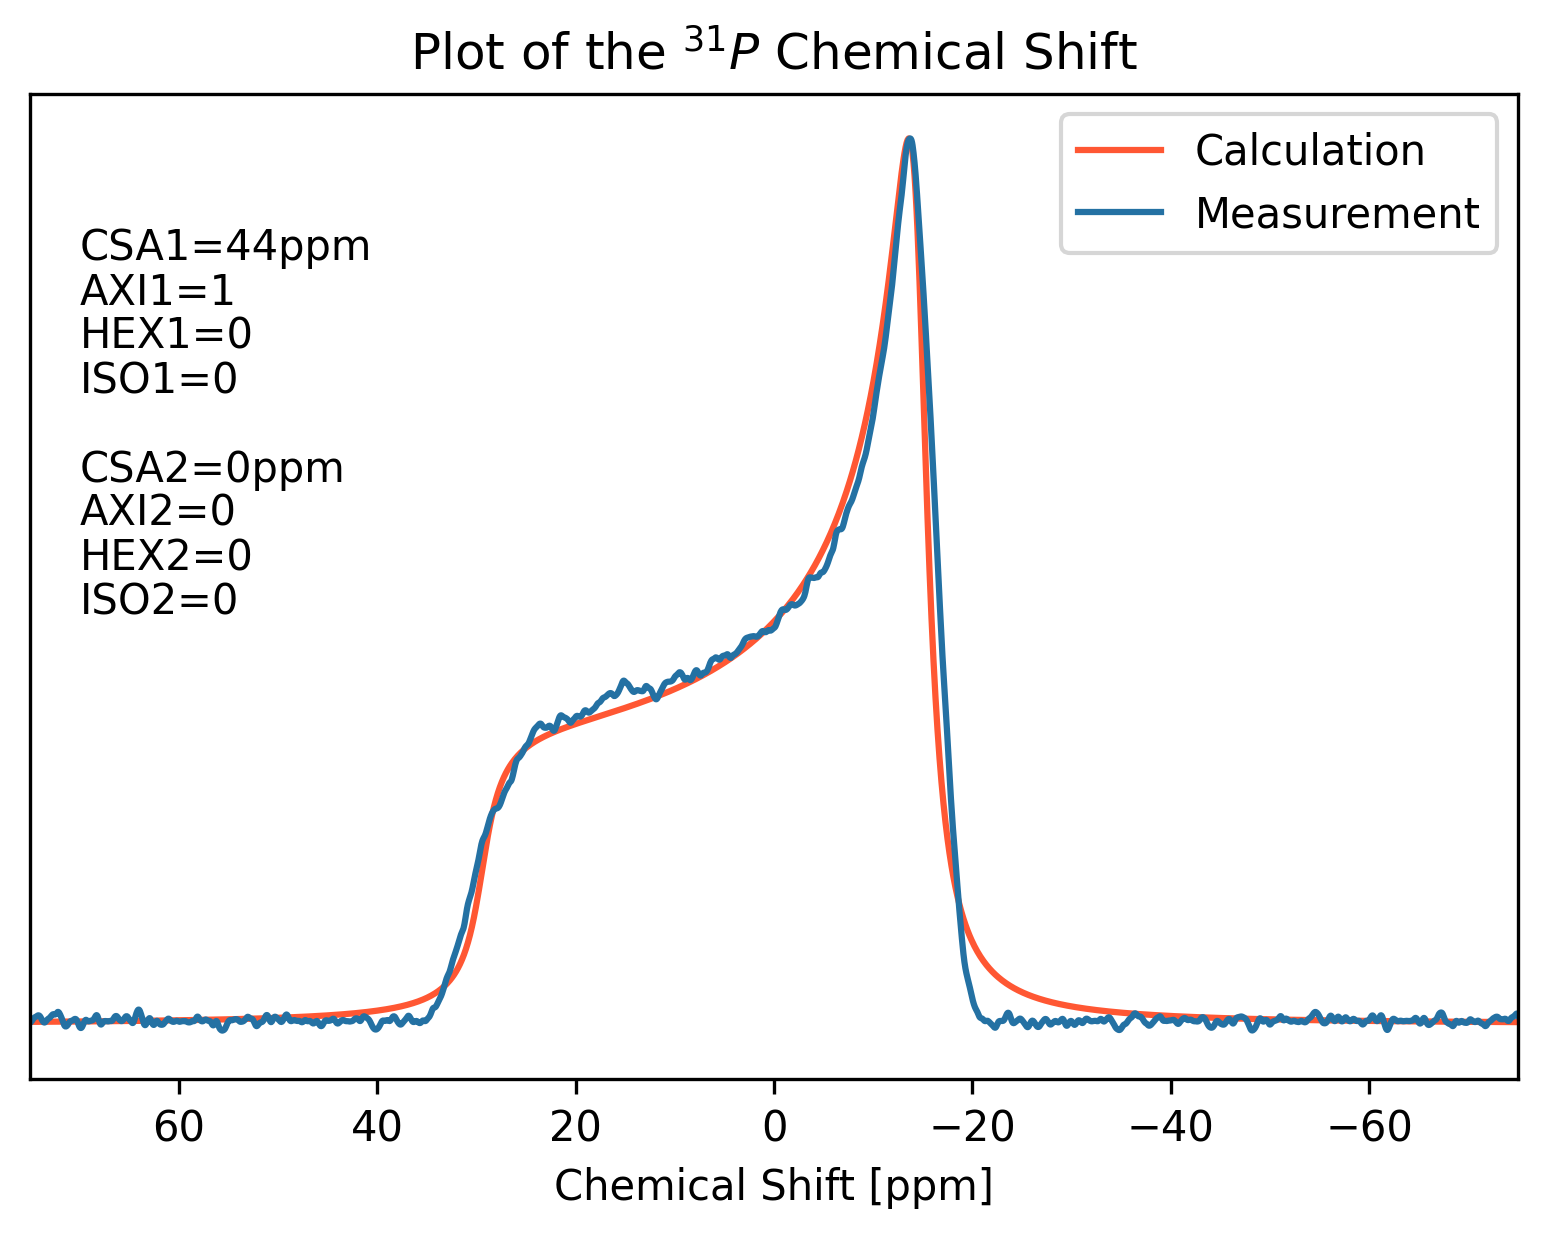

In [22]:
###PARAMETERS
LBaxi_1,LBaxi_2=770,0
LBhex_1,LBhex_2=300,0
LBiso_1,LBiso_2=300,0

csa1,csa2=44,0

#Calculate delta
delta1=float(-(2/float(3))*csa1*w_0)
delta2=float(-(2/float(3))*csa2*w_0)

c1,a1=1.0,1.1
c2,a2=1.0,0.99

axi1,axi2=1,0
hex1,hex2=0,0
iso1,iso2=0,0

drift1,drift2=0,0
plotdrift=-0
isoshift1,isoshift2=0,0

y_simul=calulate_FID_and_FFT(LBaxi_1,LBaxi_2,LBhex_1,LBhex_2,LBiso_1,LBiso_2,csa1,csa2,axi1,axi2,hex1,hex2,iso1,iso2,a1,a2,c1,c2,w_larmor,TD,w_0,delta1,delta2,DW,isoshift1,isoshift2)
plot_spectra(y_simul,csa1,csa2,axi1,axi2,hex1,hex2,iso1,iso2)